In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
words[:8]

32033


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


#### BATCH NORMALISATION



Internal Covariate Shift Reduction:
	•	During training, the distribution of each layer’s inputs changes as the parameters of the previous layers change. This phenomenon is known as internal covariate shift.
	•	Batch normalization reduces this shift by normalizing the inputs of each layer, thereby stabilizing the learning process.
   
1. We don't want the values pre-activation to be very small as `tanh` won't do much if they are.
2. We don't want them to be too big either, because then `tanh` will become saturated.
3. So, we want them to be roughly Gaussian, at least at initialization.
4. With batch normalization, we can just normalize (make them Gaussian) the hidden states.
5. However, we don't want to force them to always be Gaussian and allow the distribution to change during training.
6. We take these normalized values and scale them by multiplying with a parameter and shift them by adding a parameter:
   \[
   \text{BN}(g,b)(x_i) \rightarrow y_i \rightarrow g \cdot x_i(\text{normalized}) + b
   \]
7. At initialization, \( g = 1 \), \( b = 0 \), so that the distribution is exactly unit Gaussian.
8. We normalize the batches, not the complete state.

BatchNorm as a Regularizer

	1.	Mini-Batch Variability:
	•	Each mini-batch is a random sample of the training data, so the computed mean and variance for normalization will differ between mini-batches.
	•	This introduces noise in the input to each layer because the same input will be normalized differently depending on the mini-batch it is in.
	2.	Noise Injection:
	•	The noise injected by batch normalization can be thought of as a form of stochastic noise that helps the model generalize better.
	•	This stochastic noise forces the network to rely less on the exact outputs of previous layers and more on the overall structure and patterns in the data.


In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# batch norm params
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))

# all params
parameters = [C, W1, b1, W2, b2,bngain, bnbias]


print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


In [8]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # batch normalisation 
  hpreact =( hpreact - hpreact.mean(0,keepdim=True))/hpreact.std(0,keepdim=True)
  hpreact=  bngain * (hpreact) + bnbias
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 #  output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  #break

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


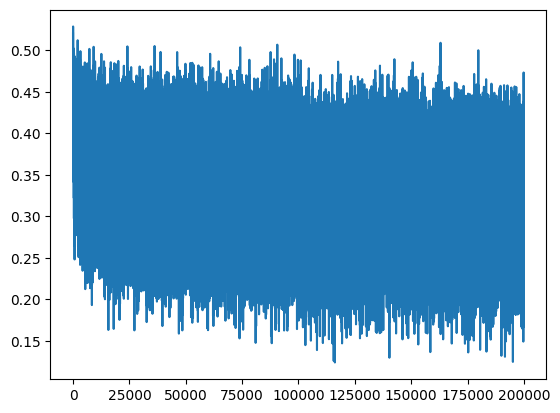

In [15]:
# after training completely
plt.plot(lossi)

If batchnorm relies on all examples of a batch to calulate statistics, then how will we use it when we are doing inference, coz at inference we may only have one sample at a time

	1.	instead on using examples of batch, while training we can calculate the mean,std of the complete training set

    2.  When we are doing inference, we will replace the batch mean,std with the mean,std over complete training set

    


In [16]:
# calibrate the batch norm at the end of training
with torch.no_grad():
    # pass the training set through
    emb=C[Xtr]
    embcat = emb.view(emb.shape[0],-1)
    hpreact  = embcat @ W1 + b1
    # measure the mean/std over the training set
    bnmean = hpreact.mean(0,keepdim=True)
    bnstd = hpreact.std(0,keepdim=True)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking for operations done by the following function, almost like all the tensor created here have requires_grad= False, we can also use a context manager with torch.nograd
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  + b1 # h pre/before activations
  # batch normalisation 
  #hpreact =( hpreact - hpreact.mean(0,keepdim=True))/hpreact.std(0,keepdim=True)
  hpreact =(hpreact - bnmean)/bnstd

  # using the training stats to normalise

  hpreact=  bngain * (hpreact) + bnbias
  
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.1049270629882812


No one wats to estimate this bnmean and bnstd after training coz everyone's lazy
Ideally we would want this to be a part during training itself. So we use the following approach

## Retraining with this in mind


In [30]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd*block_size)**0.5)
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# batch norm params
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))

bnmean_running = torch.zeros((1,n_hidden)) # non trainable param, calculated on side during training but used only for inference
bnstd_running = torch.ones((1,n_hidden))  # non trainable param, calculated on side during training but used only for inference

# all params
#parameters = [C, W1, b1, W2, b2,bngain, bnbias]
parameters = [C, W1, W2, b2,bngain, bnbias]


print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [31]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # batch normalisation 
  bnmeani = hpreact.mean(0,keepdim=True)
  bnstdi = hpreact.std(0,keepdim=True)
  hpreact =(hpreact -bnmeani )/bnstdi
  hpreact=  bngain * (hpreact) + bnbias

  momentum = 0.001
  with torch.no_grad(): # this update is outside and on the side of gradient based optimisation
    bnmean_running = (1-momentum)*bnmean_running + momentum*bnmeani # 0.00
    bnstd_running = (1-momentum)*bnstd_running + momentum*bnstdi

     
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 #  output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  #break

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6413
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


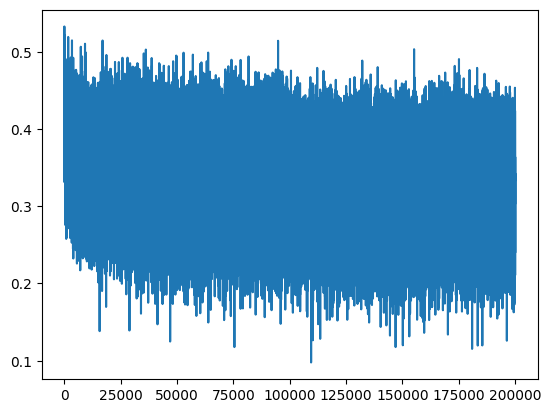

In [32]:
# after training completely
plt.plot(lossi)

In [33]:
@torch.no_grad() # this decorator disables gradient tracking for operations done by the following function, almost like all the tensor created here have requires_grad= False, we can also use a context manager with torch.nograd
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  #+ b1 # h pre/before activations
  # batch normalisation 
  #hpreact =( hpreact - hpreact.mean(0,keepdim=True))/hpreact.std(0,keepdim=True)
  hpreact =(hpreact - bnmean_running)/bnstd_running

  # using the training stats to normalise

  hpreact=  bngain * (hpreact) + bnbias
  
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674145221710205
val 2.1056838035583496


In [ ]:
# its common to sprinkle batch normalisation layers in the neural network
# usually after layers that contain multiplication operations like a linear layer or a convolutional layer
# batch norm itself has 2 params gain and bias that are optimised during training
# batch norm also has 2 buffers which are (mean(running mean) and std dev(running mean of the std dev)), these are not trained during backprop but trained using the janky running mean update
# the buffers are useful during inference, since we dont want to depend on the batch during inf, we use the buffers
# there is an epsilon parameter when youre normalising values in BN, epsilon is a small number usually 1e-5 
# epsilon is basically preventing a division by zero, incase when variance of the batch is exactly 0 

# the bias we used earlier in hpreact are useless as they are getting subtracted when youre subtracting bnmeani
#  so these biases are not doing anything and hence we don't need to define them at all (b1.grad will be zero)

# so whenever we are using batch norm layer and we have weight layers like linear or conv, then we don't need to include bias in them
# instead now we have the bnbias which is incharge of biasing the distribution

#if batch size is high we can expect roughly same mean,std for each batch so we can use higher value (0.1) for momentum
# but when the batch size is small(like 32) the mean and std of each batch may vary more because the number of examples are less
# so we don't want to be using high momentum if batch size is small coz then the running mean and std may be trashing too much and might not be able to converge properly



In [37]:
# sampling
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out =[]
    context = [0]*block_size # initialize with all ...
    while True:
        es = C[torch.tensor([context])]
        h = es.view(1,-1) @ W1
        hn = (h - bnmean_running)/bnstd_running
        hn=  bngain * (hn) + bnbias

        hs = torch.tanh(hn )
        logits = hs @ W2 + b2
        probs = F.softmax(logits,dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1,generator=g).item()
        # shift the context window and track the samples
        context = context[1:]+[ix]
        out.append(ix)
        # if we sample the '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carlah.
amorie.
khi.
mri.
reity.
salaysie.
mahnen.
delynn.
jareei.
ner.
kiah.
maiivia.
leigh.
ham.
joce.
quint.
salin.
alianni.
wate.
madiaryn.


In [ ]:
# Batch normalisation is not so frequently used these days,
# Instead use of Group Normalisation and Layer Normalisation is more common